# **ML Models comparative analysis on Forest Cover Type Dataset**

## Team Details

|            |          |                     |
|------------|----------|---------------------|
| Subject    |          | Machine Learning    |
| Supervisor |          | Prof. Aswin Kannan  |
|            |          |                     |
| Team Name  |          | MT2025724_MT2025732 |
| Member 1   | Name:    | Shreya Gupta        |
|            | Roll No: | MT2025724           |
| Member 2   | Name:    | Anirudh Sharma      |
|            | Roll No: | MT2025732           |
|            |          |                     |


## System Imports

In [1]:
!pip install chime joblib pandas numpy scipy scikit-learn xgboost lightgbm matplotlib seaborn tqdm ipython imbalanced-learn optuna

In [2]:
import chime
import random, time, json, os
import functools, itertools
import warnings, joblib, inspect

import pandas as pd, numpy as np, scipy as sp
import sklearn as skl, xgboost as xgb, lightgbm as lgb
from imblearn.over_sampling import SMOTENC
import optuna

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tqdm import tqdm
import IPython.display as d

## Helper Functions

### Notification System Setup

In [3]:
# Set notification sound
chime.theme("material")
chime.info()

### Functional Setup

In [4]:
for working_directory in ["dumps", "report/figures", "report/sections", "report/settings",
                          "report/tables"]:
    os.makedirs(working_directory, exist_ok=True)


# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)


def flatten(obj):
    if hasattr(obj, '__iter__') and not isinstance(obj, str):
        if hasattr(obj[0], '__iter__') and not isinstance(obj[0], str):
            return list(itertools.chain.from_iterable(obj))
        return obj
    return [obj]

### PyPlot Setup

In [5]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
sml_fig_sq = (4, 4)
wid_fig = (8, 3)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(
        suptitle: str = None,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
        constrained=False):
    file_name = suptitle or title
    file_name = file_name.replace(':', '_').replace('/', '_')

    compose(plt.xlabel, x_label, font_label)
    compose(plt.ylabel, y_label, font_label)
    compose(plt.xticks, x_ticks, font_ticks)
    compose(plt.yticks, y_ticks, font_ticks)

    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()

    plt.savefig(f'report/figures/plot_{file_name}.png', dpi=300)

    compose(plt.suptitle, suptitle, font_suptitle)
    compose(plt.title, title, font_title)

    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()

    plt.show()


def conclude_csv(ds: pd.DataFrame, name=None, index=False, transpose=False):
    if name is None:
        if isinstance(ds, pd.Series):
            name = ds.name
        else:
            raise NameError()
    ds = ds.copy()
    if transpose: ds = ds.transpose()
    ds = ds.round(2)
    ds.to_csv(f'report/tables/data_{name}.csv', index=index, encoding="utf-8")


chime.info()

### Randomizer Setup

In [6]:
default_seed = 42
current_seed = default_seed


def reset_seed(seed=default_seed):
    global current_seed
    current_seed = seed
    random.seed(seed)
    np.random.seed(seed)


chime.info()

### Presentor Setup

In [7]:
displayMD = lambda x: display(d.Markdown(x))
kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())
header = lambda n, field: "%s %s" % ("#" * n, field)
quote = lambda field: "\n\n> %s" % field.replace("\n", "\n> ")
list_out = lambda title, list: header(4, "%s\n\n* %s" % (title, "\n* ".join(list)))

### Model Helpers

In [8]:
def save_model(model, path):
    joblib.dump(model, path)


def load_model(path):
    return joblib.load(path)


def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = skl.metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=sml_fig_sq)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    conclude_plot(title, True)


def displayAUCScore(test_x, test_y, model):
    try:
        auc_score = None
        if len(np.unique(test_y)) == 2:
            test_prob_y = model.predict_proba(test_x)[:, 1]
            auc_score = skl.metrics.roc_auc_score(test_y, test_prob_y)
        elif len(np.unique(test_y)) > 2 and hasattr(model, "predict_proba"):
            test_prob_y = model.predict_proba(test_x)
            auc_score = skl.metrics.roc_auc_score(test_y, test_prob_y, multi_class='ovr', average='macro')

        if auc_score is not None:
            displayMD(header(4, kv('Test Multiclass ROC AUC Score (OVR)', f"{auc_score:.4f}")))
    except Exception as e:
        displayMD(f"**Note:** AUC score failed to calculate: {e}")


def evaluate_model(model, train_x, train_y, test_x, test_y, silent=False, name=None):
    if name is None:
        name = model.__class__.__name__

    reset_seed()
    model.fit(train_x, train_y)

    train_pred_y = model.predict(train_x)
    test_pred_y = model.predict(test_x)

    if not silent: displayMD(header(3, f"Evaluation: {name}"))

    train_accuracy = skl.metrics.accuracy_score(train_y, train_pred_y)
    test_accuracy = skl.metrics.accuracy_score(test_y, test_pred_y)

    if not silent:
        displayMD(header(4, kv('Train Accuracy', f"{train_accuracy:.4f}")))
        displayMD(header(4, kv('Val Accuracy', f"{test_accuracy:.4f}")))
        displayAUCScore(test_x, test_y, model)
        plot_confusion_matrix(test_y, test_pred_y, target_labels, title=f"Confusion Matrix: {name}")

    return train_accuracy, test_accuracy

## Data Loading and Description

In [9]:
ds_source = pd.read_csv("covtype.csv")
chime.info()

In [10]:
ds_source.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [11]:
n_samples_all, n_columns = ds_source.shape
n_features_raw = n_columns - 1  # targets (Cover_Type)

target_labels = ds_source['Cover_Type'].unique()
n_targets = len(target_labels)

displayMD(header(4, kv('Number of total samples', n_samples_all)))
displayMD(header(4, kv('Number of total columns', n_columns)))
displayMD(header(4, kv('Number of features', n_features_raw)))
displayMD(header(4, kv('Number of classes in target feature', n_targets)))
conclude_csv(pd.DataFrame([['Total Samples', n_samples_all], ['Total Columns', n_columns], ['Features', n_features_raw],
                           ['Targets', n_targets], ], columns=['Stat', 'Meta']), 'dataset_statistics')

#### **Number of total samples:** `581012`

#### **Number of total columns:** `55`

#### **Number of features:** `54`

#### **Number of classes in target feature:** `7`

In [12]:
column_full_names = {
    'Elev': 'Elevation', 'Aspc': 'Aspect', 'Slpe': 'Slope', 'HDTH': 'Horizontal_Distance_To_Hydrology',
    'VDTH': 'Vertical_Distance_To_Hydrology', 'HDTR': 'Horizontal_Distance_To_Roadways', 'H09A': 'Hillshade_9am',
    'H12P': 'Hillshade_Noon', 'H03P': 'Hillshade_3pm', 'HDFP': 'Horizontal_Distance_To_Fire_Points',
    'WA1': 'Wilderness_Area1', 'WA2': 'Wilderness_Area2', 'WA3': 'Wilderness_Area3', 'WA4': 'Wilderness_Area4',
    'ST01': 'Soil_Type1', 'ST02': 'Soil_Type3', 'ST03': 'Soil_Type4', 'ST04': 'Soil_Type2', 'ST05': 'Soil_Type5',
    'ST06': 'Soil_Type6', 'ST07': 'Soil_Type7', 'ST08': 'Soil_Type8', 'ST09': 'Soil_Type9', 'ST10': 'Soil_Type10',
    'ST11': 'Soil_Type11', 'ST12': 'Soil_Type12', 'ST13': 'Soil_Type13', 'ST14': 'Soil_Type14', 'ST15': 'Soil_Type15',
    'ST16': 'Soil_Type16', 'ST17': 'Soil_Type17', 'ST18': 'Soil_Type18', 'ST19': 'Soil_Type19', 'ST20': 'Soil_Type20',
    'ST21': 'Soil_Type21', 'ST22': 'Soil_Type22', 'ST23': 'Soil_Type23', 'ST24': 'Soil_Type24', 'ST25': 'Soil_Type25',
    'ST26': 'Soil_Type26', 'ST27': 'Soil_Type27', 'ST28': 'Soil_Type28', 'ST29': 'Soil_Type29', 'ST30': 'Soil_Type30',
    'ST31': 'Soil_Type31', 'ST32': 'Soil_Type32', 'ST33': 'Soil_Type33', 'ST34': 'Soil_Type34', 'ST35': 'Soil_Type35',
    'ST36': 'Soil_Type36', 'ST37': 'Soil_Type37', 'ST38': 'Soil_Type38', 'ST39': 'Soil_Type39', 'ST40': 'Soil_Type40',
    'CT': 'Cover_Type',
}

In [13]:
column_full_names_t = {v: k for k, v in column_full_names.items()}
ds_source.columns = [column_full_names_t[x] for x in ds_source.columns]

In [14]:
info = pd.io.formats.info.DataFrameInfo(
    data=ds_source,
    memory_usage=None,
)
ds_info = pd.DataFrame(zip(info.ids, info.ids.map(column_full_names), info.non_null_counts, info.dtypes),
                       columns=['Column Name', 'Description', 'Non-Null Count', 'Data Type'])

In [15]:
displayMD(header(3, kv('Memory Usage', info.memory_usage_string)))
conclude_csv(ds_info, "dataset_info")
display(ds_info)

### **Memory Usage:** `243.8 MB`

,Column Name,Description,Non-Null Count,Data Type
0,Elev,Elevation,581012,int64
1,Aspc,Aspect,581012,int64
2,Slpe,Slope,581012,int64
3,HDTH,Horizontal_Distance_To_Hydrology,581012,int64
4,VDTH,Vertical_Distance_To_Hydrology,581012,int64
5,HDTR,Horizontal_Distance_To_Roadways,581012,int64
6,H09A,Hillshade_9am,581012,int64
7,H12P,Hillshade_Noon,581012,int64
8,H03P,Hillshade_3pm,581012,int64
9,HDFP,Horizontal_Distance_To_Fire_Points,581012,int64


In [16]:
# Display column datatype-wise

gb_info_by_dtype = ds_info.groupby('Data Type')['Column Name'].apply(list)
ds_dtype = pd.DataFrame({
    t: items + ['-'] * (gb_info_by_dtype.map(len).max() - len(items))
    for t, items in gb_info_by_dtype.items()
})
conclude_csv(ds_dtype, "dataset_dtypes")
display(ds_dtype)

,int64
0,Elev
1,Aspc
2,Slpe
3,HDTH
4,VDTH
5,HDTR
6,H09A
7,H12P
8,H03P
9,HDFP


In [17]:
# Display first five rows of the data

conclude_csv(ds_source.head(5), "dataset_head")
display(ds_source.head(5))

,Elev,Aspc,Slpe,HDTH,VDTH,HDTR,H09A,H12P,H03P,HDFP,...,ST32,ST33,ST34,ST35,ST36,ST37,ST38,ST39,ST40,CT
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [18]:
# Display statistical data analysis for both numerical and categorical columns

ds_describe = ds_source.describe(include='all')
ds_describe.index = ['count', 'mean', 'std', 'min', '25', '50', '75', 'max']
conclude_csv(ds_describe
             .map(lambda y: np.round(y, 2) if isinstance(y, float) else y)
             .map(lambda y: (y[:5] + '.') if isinstance(y, str) else y)
             .fillna("_"), "dataset_describe", index=True, transpose=True)
display(ds_describe)

,Elev,Aspc,Slpe,HDTH,VDTH,HDTR,H09A,H12P,H03P,HDFP,...,ST32,ST33,ST34,ST35,ST36,ST37,ST38,ST39,ST40,CT
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [19]:
# Separate out the various categories of features

target_columns = ['CT']

numerical_features = ['Elev', 'Aspc', 'Slpe', 'HDTH', 'VDTH', 'HDTR', 'H09A', 'H12P', 'H03P', 'HDFP', 'WA1', 'WA2',
                      'WA3', 'WA4', 'ST01', 'ST04', 'ST02', 'ST03', 'ST05', 'ST06', 'ST07', 'ST08', 'ST09', 'ST10',
                      'ST11', 'ST12', 'ST13', 'ST14', 'ST15', 'ST16', 'ST17', 'ST18', 'ST19', 'ST20', 'ST21', 'ST22',
                      'ST23', 'ST24', 'ST25', 'ST26', 'ST27', 'ST28', 'ST29', 'ST30', 'ST31', 'ST32', 'ST33', 'ST34',
                      'ST35', 'ST36', 'ST37', 'ST38', 'ST39', 'ST40']

gaussian_features = numerical_features[:10]
wilderness_features = numerical_features[10:14]
soiltype_features = numerical_features[14:]

label_encoder = {label: index for index, label in enumerate(target_labels)}
label_decoder = {index: label for index, label in enumerate(target_labels)}

## Exploratory Data Analysis

#### Missing Value Detection

In [20]:
ds_missing = ds_source.isnull().sum().to_frame(name='Missing Count')
conclude_csv(ds_missing, "eda_missing_counts", index=True)
display(ds_missing)

,Missing Count
Elev,0
Aspc,0
Slpe,0
HDTH,0
VDTH,0
HDTR,0
H09A,0
H12P,0
H03P,0
HDFP,0


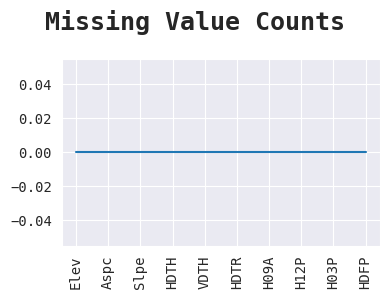

In [21]:
ax = ds_missing[:10].plot(kind='line', figsize=sml_fig, legend=False)
ax.set_xticks(range(len(gaussian_features)), gaussian_features, rotation=90, **font_ticks)
conclude_plot("Missing Value Counts")

#### Outlier Detection

In [22]:
# Find the number of values below or above the IQR

def count_outliers(ds: pd.DataFrame, column: str):
    quan25 = ds[column].quantile(0.05)
    quan75 = ds[column].quantile(0.95)
    iqr = quan75 - quan25
    lower_limit = quan25 - 1.5 * iqr
    upper_limit = quan75 + 1.5 * iqr
    outlier_mask = (ds[column] > upper_limit) | (ds[column] < lower_limit)
    return len(ds[outlier_mask]), outlier_mask


_ds_num = ds_source
ds_outliers = pd.DataFrame(zip(_ds_num.columns, [count_outliers(_ds_num, col)[0] for col in _ds_num.columns]),
                           columns=['', 'Outliers_Count'])
conclude_csv(ds_outliers, "eda_outlier_counts")
display(ds_outliers)

,,Outliers_Count
0,Elev,0
1,Aspc,0
2,Slpe,3
3,HDTH,0
4,VDTH,173
5,HDTR,0
6,H09A,13
7,H12P,32
8,H03P,0
9,HDFP,0


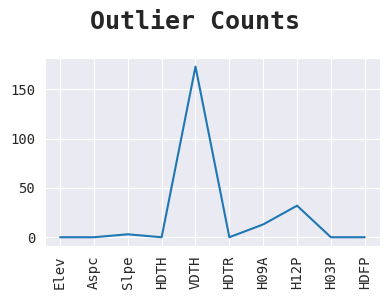

In [23]:
ax = ds_outliers[:10].plot(kind='line', figsize=sml_fig, legend=False)
ax.set_xticks(range(len(gaussian_features)), gaussian_features, rotation=90, **font_ticks)
conclude_plot("Outlier Counts")

#### Duplicates Detection

In [24]:
ds_duplicates = ds_source.duplicated()
conclude_csv(ds_duplicates, "eda_duplicate_counts", index=True)
ds_duplicates

0         False
1         False
2         False
3         False
4         False
          ...  
581007    False
581008    False
581009    False
581010    False
581011    False
Length: 581012, dtype: bool

#### Feature Distribution Analysis - Numerical, Categorical, Numerical feature spread and Sensitivity of outliers

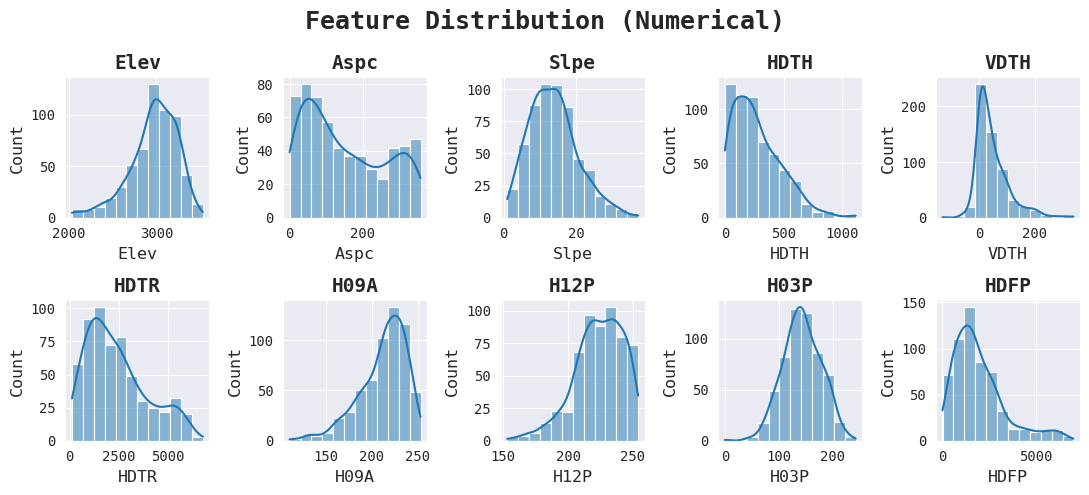

In [25]:
# Feature distribution plots for each of the numerical features

fig, axs = plt.subplots(2, 5, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), gaussian_features):
    sns.histplot(ds_source[col][::1000], kde=True, bins=12, ax=ax)
    annotate_plot(ax, col)
conclude_plot("Feature Distribution (Numerical)")

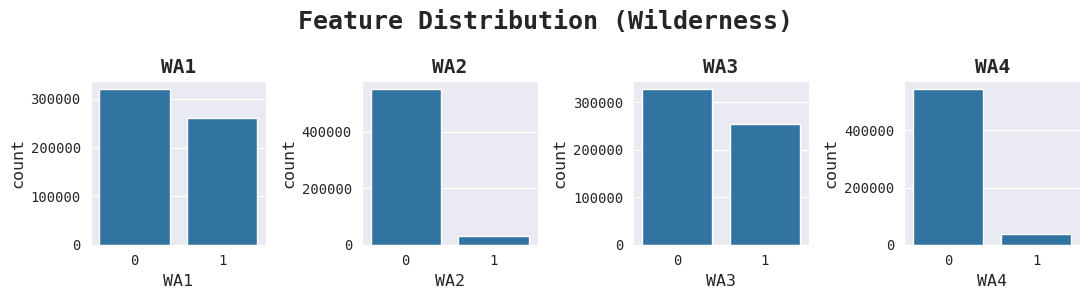

In [26]:
# Feature distribution plots for each of the numerical features

fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
for ax, col in zip(flatten(axs), wilderness_features):
    sns.countplot(x=ds_source[col], ax=ax)
    annotate_plot(ax, col)
conclude_plot("Feature Distribution (Wilderness)")

In [27]:
ds_source['WA4'].std(), ds_source['WA2'].std()

(np.float64(0.24408734404115698), np.float64(0.22088227835340093))

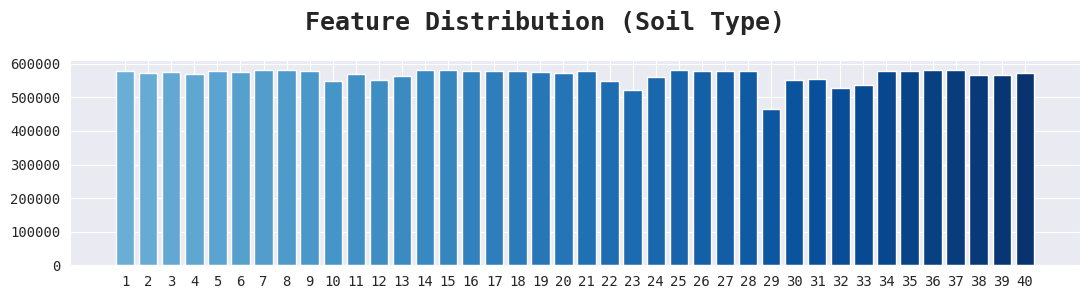

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(max_fig_width, 3))
lef, rig = mpl.colormaps['Blues'], mpl.colormaps['Greens']
for idx, col in enumerate(soiltype_features):
    ax.bar(x=idx + 1, height=ds_source[col].value_counts()[0], color=lef(0.5 + idx / 80))
ax.set_xticks(range(1, 41), list(map(str, range(1, 41))))
conclude_plot("Feature Distribution (Soil Type)")

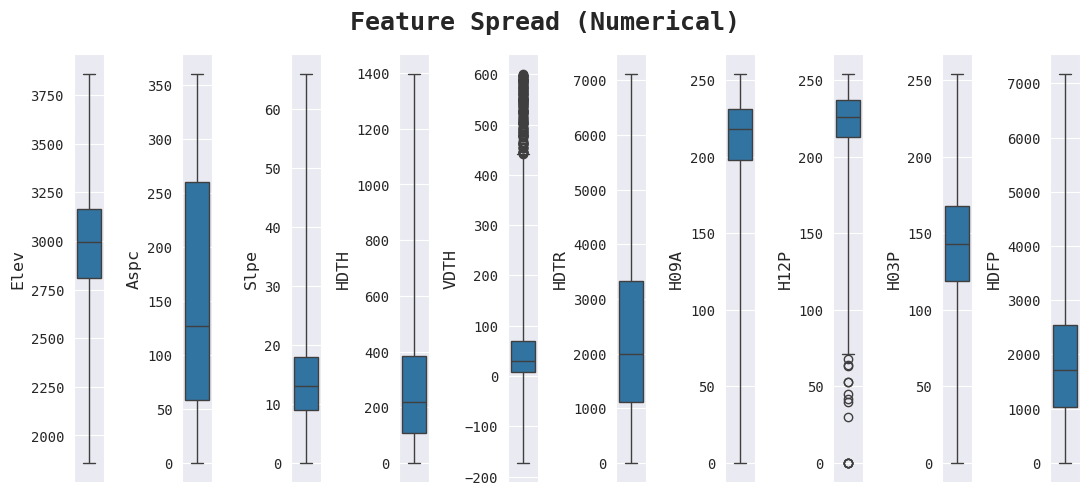

In [29]:
fig, axs = plt.subplots(1, 10, figsize=(max_fig_width, 5))
for ax, column in zip(flatten(axs), numerical_features):
    sns.boxplot(y=column, data=ds_source, ax=ax, whis=6)
conclude_plot("Feature Spread (Numerical)")

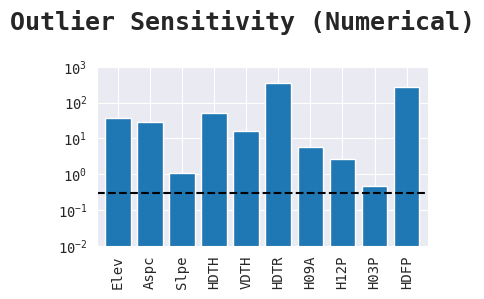

In [30]:
# Plot for analyzing the sensitivity of the numerical features to outliers

plt.figure(figsize=sml_fig)
_ds_num = ds_source[gaussian_features]
(_ds_num.mean() - _ds_num.median()).abs().plot(kind='bar', width=0.8)
plt.yscale('log'), plt.ylim(0.01, 1000)
plt.axhline(0.3, color='black', linestyle='--')
conclude_plot("Outlier Sensitivity (Numerical)")

#### Correlation Analysis

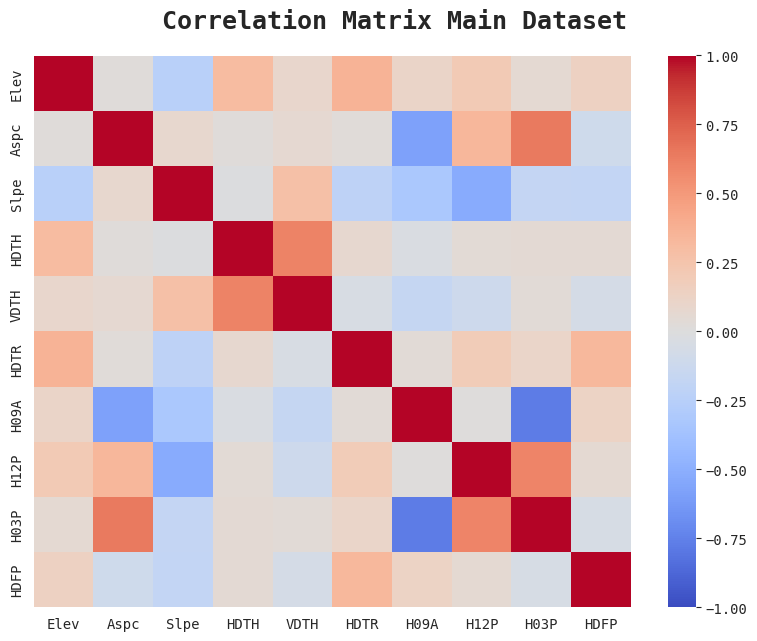

In [31]:
plt.figure(figsize=(8, 6.5))
_corr_matrix = ds_source[gaussian_features].corr()
sns.heatmap(_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
conclude_plot("Correlation Matrix Main Dataset", True)

#### Experimentation with PCA

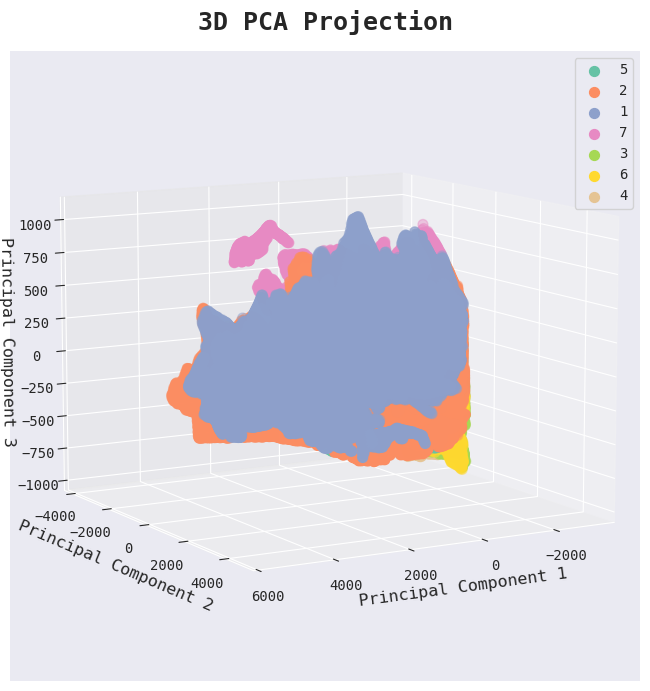

In [32]:
_pca = skl.decomposition.PCA(n_components=3).fit_transform(ds_source.drop(columns='CT'))
_ds_pca = pd.DataFrame(data=_pca, columns=['PC1', 'PC2', 'PC3'])
_ds_pca['Class'] = ds_source['CT']
fig = plt.figure(figsize=(max_fig_width, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=60)
colors = sns.color_palette("Set2", len(_ds_pca['Class'].unique()))
for i, label in enumerate(_ds_pca['Class'].unique()):
    subset = _ds_pca[_ds_pca['Class'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=label, s=50, color=colors[i])
ax.set_xlabel('Principal Component 1'), ax.set_ylabel('Principal Component 2'), ax.set_zlabel('Principal Component 3')
ax.legend()
conclude_plot('3D PCA Projection')

## Data Pre-Processing

### Handling Numerical Features

As seen in the visualizations, several distributions are significantly skewed away from the center.

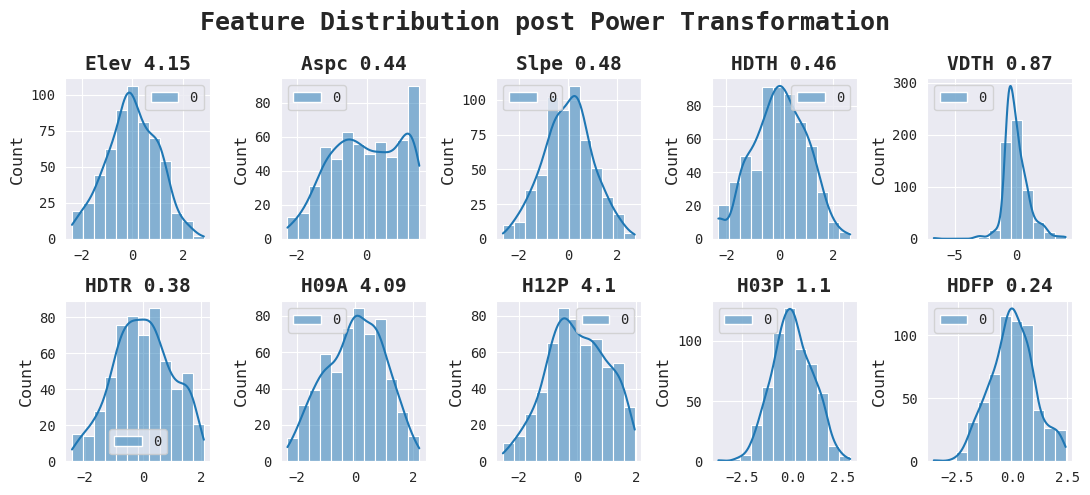

In [33]:
# Feature distribution plots for each of the numerical features

fig, axs = plt.subplots(2, 5, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), gaussian_features):
    data = ds_source[col][::1000].to_numpy().reshape(-1, 1)
    pt = skl.preprocessing.PowerTransformer()
    data = pt.fit_transform(data)
    sns.histplot(data, kde=True, bins=12, ax=ax)
    annotate_plot(ax, f"{col} {round(pt.lambdas_[0], 2)}")
conclude_plot("Feature Distribution post Power Transformation")

### Handling Categorical Features

Already OHEd

## Data Pipelining

#### Train Test Split


In [34]:
_data_x, _data_y = ds_source.drop(columns=['CT']), ds_source['CT']

train_x, test_x, train_y, test_y = skl.model_selection.train_test_split(
    _data_x, _data_y, test_size=0.04, random_state=current_seed, stratify=_data_y)

print("Training Set Size  :", train_x.shape[0])
print("Test Set Size      :", test_x.shape[0])

Training Set Size  : 557771
Test Set Size      : 23241


#### SK Learn Pipeline

In [35]:
transformer = skl.compose.ColumnTransformer(
    transformers=[
        ('power', skl.preprocessing.PowerTransformer(), gaussian_features),
        ('pass', 'passthrough', wilderness_features + soiltype_features),
    ]
)

train_x = transformer.fit_transform(train_x)
test_x = transformer.transform(test_x)

transformer

,transformers,"[('power', ...), ('pass', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,method,'yeo-johnson'
,standardize,True
,copy,True


## Modelling

#### Train-Test Splitting and Experiment Setup

In [36]:
def conduct_simple_experiment(model, silent=False):
    global train_x, test_x, train_y, test_y
    train_acc, test_acc = evaluate_model(model, train_x, train_y, test_x, test_y, silent)
    if not silent: chime.info()
    return train_acc, test_acc


def conduct_grid_search_experiment(name, search_space, model_supplier,
                                   skip_control=None, derived_parameters=None, verbose=-1):
    global train_x, test_x, train_y, test_y

    start_time = time.perf_counter()

    history = []

    pbar = [dict(zip(search_space.keys(), values)) for values in itertools.product(*search_space.values())]
    if verbose == -1: pbar = tqdm(pbar)

    for parameters in pbar:
        if skip_control is not None and skip_control(parameters):
            continue
        if derived_parameters is not None:
            derived_parameters(parameters)

        key = ",".join(["%s=%s" % (k, v) for k, v in parameters.items()])
        if verbose >= 0:  print("Training Model with configurations", key)
        if verbose == -1: pbar.set_description("Processing %s" % key)

        cons_args = inspect.signature(model_supplier).parameters.keys()
        if 'verbose' in cons_args and verbose > 0: parameters['verbose'] = verbose
        if 'n_jobs' in cons_args: parameters['n_jobs'] = 15
        if 'random_state' in cons_args: parameters['random_state'] = current_seed
        if 'cv' in cons_args: parameters['cv'] = 5

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                model = model_supplier(**parameters)
                model.fit(train_x, train_y)
                history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                                      'val score': model.score(test_x, test_y)}])
        except Exception as e:
            if verbose >= 1: print("This config is not compatible:", e)

    elapsed_time = time.perf_counter() - start_time
    best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])
    search_space_size = len(pbar)

    # save_submission(name + '_' + best_config, best_model, data_test_ids, data_test, data_y_codex)

    displayMD(header(4, kv('Best Val Accuracy', best_score)))
    displayMD(header(4, kv('Time Elapsed', f"{elapsed_time:.4f} seconds")))

    chime.success()
    return history, best_score, best_config, best_model, elapsed_time, search_space_size


def conduct_grid_search_experiment_v2(name, search_space, model_supplier, cv=5, verbose=1, fresh=False, n_jobs=12, test_fit=False):
    global train_x, test_x, train_y, test_y

    if not fresh:
        try:
            history, best_score, best_config, best_model, elapsed_time, search_space_size = joblib.load(
                f"dumps/history_{name}.pkl")
            displayMD(header(3, f"Evaluation: {name}"))
            displayMD(header(4, kv('Best Val Accuracy', best_score)))
            displayMD(header(4, kv('Time Elapsed', f"{elapsed_time:.4f} seconds")))
            displayAUCScore(test_x, test_y, best_model)
            plot_confusion_matrix(test_y, best_model.predict(test_x), target_labels, title=f"Confusion Matrix: {name}")
            return history, best_score, best_config, best_model, elapsed_time, search_space_size
        except:
            pass

    start_time = time.perf_counter()

    history = []

    parameters = {}
    cons_args = inspect.signature(model_supplier).parameters.keys()
    if 'verbose' in cons_args and verbose > 0: parameters['verbose'] = verbose
    if 'random_state' in cons_args: parameters['random_state'] = current_seed
    model = model_supplier(**parameters)

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            gs = skl.model_selection.GridSearchCV(model, search_space, cv=cv, verbose=max(0, verbose), n_jobs=n_jobs,
                                                  return_train_score=True, error_score='raise')
            if test_fit: gs.fit(test_x, test_y)
            else: gs.fit(train_x, train_y)
            history.extend([[",".join(["%s=%s" % (k, v) for k, v in p.items()]),
                             {'model': 'ISE', 'train score': train_sc, 'val score': test_sc,
                              'train_time': train_time, 'pred_time': pred_time, }]
                            for train_sc, test_sc, train_time, pred_time, p in
                            zip(gs.cv_results_['mean_train_score'], gs.cv_results_['mean_test_score'],
                                gs.cv_results_['mean_fit_time'], gs.cv_results_['mean_score_time'],
                                gs.cv_results_['params'])
                            if not np.isnan(test_sc)])
    except Exception as e:
        if verbose >= 1: print("Something went wrong", e)

    elapsed_time = time.perf_counter() - start_time
    best_score, best_config, best_model = gs.best_score_, gs.best_params_, gs.best_estimator_
    best_config = ",".join(["%s=%s" % (k, v) for k, v in best_config.items()])
    search_space_size = len(gs.cv_results_['params']) * gs.cv

    displayMD(header(3, f"Evaluation: {name}"))
    displayMD(header(4, kv('Best Val Accuracy', best_score)))
    displayMD(header(4, kv('Time Elapsed', f"{elapsed_time:.4f} seconds")))
    displayAUCScore(test_x, test_y, best_model)
    plot_confusion_matrix(test_y, best_model.predict(test_x), target_labels, title=f"Confusion Matrix: {name}")

    chime.success()
    joblib.dump((history, best_score, best_config, best_model, elapsed_time, search_space_size),
                f"dumps/history_{name}.pkl")
    return history, best_score, best_config, best_model, elapsed_time, search_space_size


def plot_model_comparsion(name, history):
    plt.figure(figsize=sml_fig)
    _hist = sorted([[x[1]['val score'], x] for x in history])
    if len(_hist) <= 30:
        for idx, (score, _) in enumerate(_hist):
            plt.bar(idx, score)
    else:
        for idx, (score, _) in enumerate(_hist[:15]):
            plt.bar(idx, score)
        for idx, (score, _) in enumerate(_hist[-15:]):
            plt.bar(idx + 16, score)

    print(_hist[-1][1][0])
    plt.xlabel(_hist[-1][1][0])
    plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
    conclude_plot(f"Best {name} Config")

### Logistic Regression

#### Simple LR Model

### Evaluation: LogisticRegressionCV

#### **Train Accuracy:** `0.7243`

#### **Val Accuracy:** `0.7180`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9346`

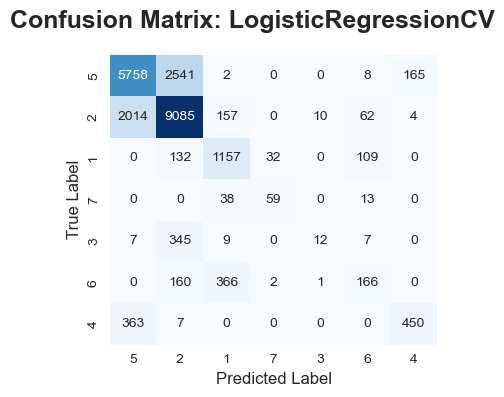

(0.7243044188385556, 0.7179983649584786)

In [37]:
conduct_simple_experiment(skl.linear_model.LogisticRegressionCV(cv=2, max_iter=100, solver='lbfgs', n_jobs=6))
# 1 min per train

#### Grid Searched Logistic Regression

### Evaluation: GSLR

#### **Best Val Accuracy:** `0.7241825058317268`

#### **Time Elapsed:** `205.1168 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9345`

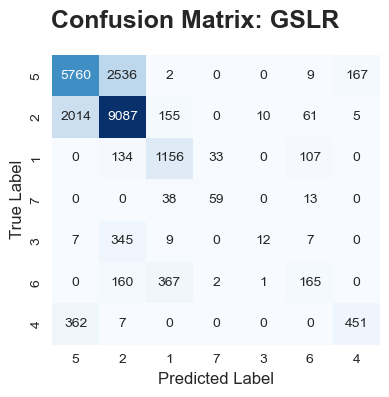

In [38]:
history_lr, *meta_lr = conduct_grid_search_experiment_v2("GSLR", search_space={
    'penalty': [None, 'l2', 'elasticnet'],
    'C': [1, 0.5],
    'l1_ratio': [0.25, 0.75],
    'solver': ['lbfgs'],
    # Works best with multiclass dataset which are also enormous and have many features. Against SAG, it also allows L1/2/EN
    'max_iter': [10000],
    'n_jobs': [2],
}, model_supplier=skl.linear_model.LogisticRegression, verbose=1, cv=2, n_jobs=3)

C=1,l1_ratio=0.75,max_iter=10000,n_jobs=2,penalty=None,solver=lbfgs


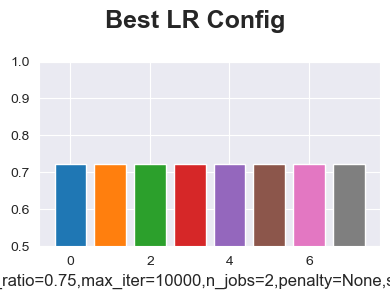

In [39]:
plot_model_comparsion("LR", history_lr)

### Support Vector Machine

#### Simple SVM Example

C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Evaluation: SVC

#### **Train Accuracy:** `0.4714`

#### **Val Accuracy:** `0.4689`

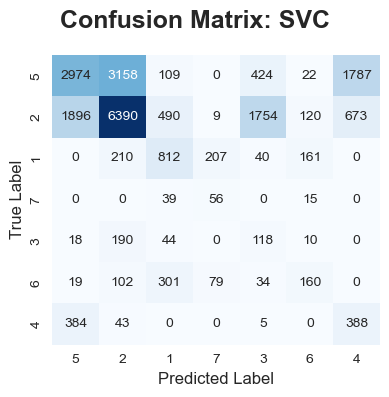

(0.47137086725555827, 0.4689126973882363)

In [40]:
conduct_simple_experiment(skl.svm.SVC(kernel='linear', C=1.0, max_iter=100))

#### Grid Searched Support Vector Machine

### Evaluation: GSSV

#### **Best Val Accuracy:** `0.42012935511146543`

#### **Time Elapsed:** `277.4149 seconds`

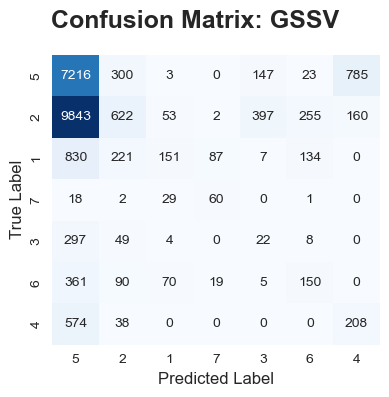

In [41]:
history_sv, *meta_sv = conduct_grid_search_experiment_v2("GSSV", search_space={
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2],
    'max_iter': [100],
}, model_supplier=skl.svm.SVC, verbose=1, cv=2, n_jobs=14)

degree=2,kernel=rbf,max_iter=100


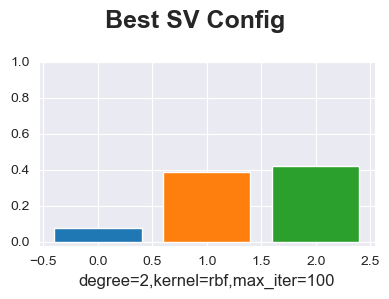

In [42]:
plot_model_comparsion("SV", history_sv)

### Multilayer Perceptron

#### Simple MLP Example

C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluation: MLPClassifier

#### **Train Accuracy:** `0.8759`

#### **Val Accuracy:** `0.8706`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9853`

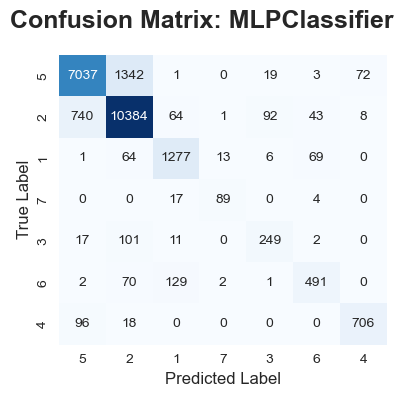

(0.8759006832553144, 0.870573555354761)

In [43]:
conduct_simple_experiment(skl.neural_network.MLPClassifier(hidden_layer_sizes=(100,), max_iter=100))

#### Grid Searched Multilayer Perceptron

### Evaluation: GSMP

#### **Best Val Accuracy:** `0.9092548683336723`

#### **Time Elapsed:** `542.9591 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9950`

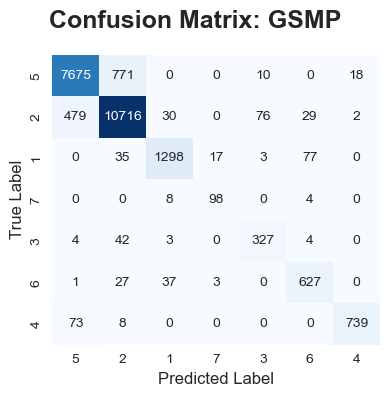

In [44]:
history_mp, *meta_mp = conduct_grid_search_experiment_v2("GSMP", search_space={
    'hidden_layer_sizes': [(100,), (200,), (100, 100)],
    'max_iter': [100],
}, model_supplier=skl.neural_network.MLPClassifier, verbose=1, cv=2)

hidden_layer_sizes=(100, 100),max_iter=100


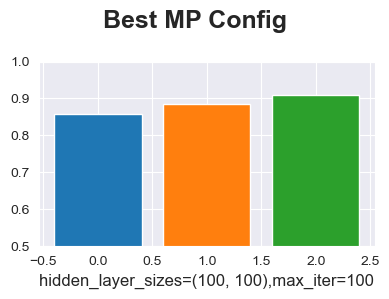

In [45]:
plot_model_comparsion("MP", history_mp)

### A simple fix for clusters, since clusters are 0-indexed

In [46]:
train_y = train_y - 1
test_y = test_y - 1

### K Means

#### Simple KM Example

In [69]:
class KMeans(skl.cluster.KMeans):
    def score(self, X, y=None, sample_weight=None):
        return skl.metrics.accuracy_score(y, self.predict(X))

### Evaluation: KMeans

#### **Train Accuracy:** `0.1357`

#### **Val Accuracy:** `0.1367`

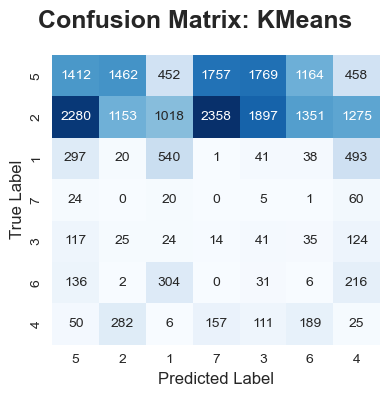

(0.13569905929135792, 0.13669807667484188)

In [70]:
conduct_simple_experiment(KMeans(n_clusters=n_targets, max_iter=300))

#### Grid Searched KMeans

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Initialization complete
Iteration 0, inertia 6266711.918237704.
Iteration 1, inertia 4073735.3574545807.
Iteration 2, inertia 3963283.6122075953.
Iteration 3, inertia 3934245.2593193003.
Iteration 4, inertia 3918084.1714340243.
Iteration 5, inertia 3905481.8481843206.
Iteration 6, inertia 3896154.07207213.
Iteration 7, inertia 3889796.140356083.
Iteration 8, inertia 3885239.609187938.
Iteration 9, inertia 3881622.027276546.
Iteration 10, inertia 3878516.0286876075.
Iteration 11, inertia 3875824.9135784823.
Iteration 12, inertia 3873435.214482717.
Iteration 13, inertia 3871265.0603241967.
Iteration 14, inertia 3869276.3293127185.
Iteration 15, inertia 3867521.569428316.
Iteration 16, inertia 3865966.579345911.
Iteration 17, inertia 3864506.251805818.
Iteration 18, inertia 3863165.543592412.
Iteration 19, inertia 3861957.4720993913.
Iteration 20, inertia 3860897.6819629655.
Iteration 21, inertia 3859948.4623177606.
Iteration 22

### Evaluation: GSKM

#### **Best Val Accuracy:** `0.16054795895944474`

#### **Time Elapsed:** `41.2525 seconds`

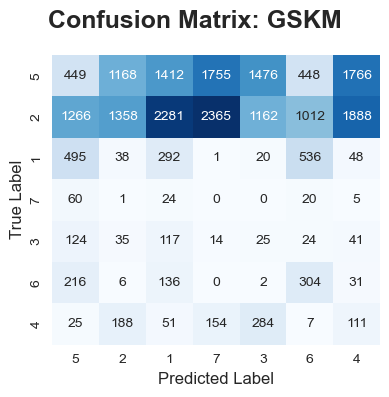

In [71]:
history_km, *meta_km = conduct_grid_search_experiment_v2("GSKM", search_space={
    'n_clusters': [n_targets],
    'max_iter': [10, 100, 200],
    'n_init': [1, 4],
    'algorithm': ['lloyd', 'elkan'],
}, model_supplier=KMeans, verbose=1, cv=2)

algorithm=lloyd,max_iter=200,n_clusters=7,n_init=4


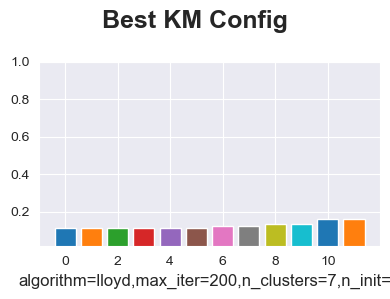

In [72]:
plot_model_comparsion("KM", history_km)

### Agglomerative Clustering

#### Simple AC Example

In [73]:
class HierarchicalClustering(skl.base.BaseEstimator, skl.base.ClusterMixin):
    def __init__(self, n_clusters=10, max_iter=10):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, x, y=None):
        self.km_ = skl.cluster.KMeans(n_clusters=self.n_clusters, max_iter=self.max_iter)
        self.ac_ = skl.cluster.AgglomerativeClustering(n_clusters=n_targets)
        coarse_labels = self.km_.fit_predict(x)
        self.cluster_centers_ = self.km_.cluster_centers_
        self.centroid_labels_ = self.ac_.fit_predict(self.cluster_centers_)
        self.labels_ = self.centroid_labels_[coarse_labels]
        return self

    def predict(self, x):
        coarse_labels = self.km_.predict(x)
        final_labels = self.centroid_labels_[coarse_labels]
        return final_labels

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.labels_

    def score(self, X, y):
        return skl.metrics.accuracy_score(y, self.predict(X))

### Evaluation: HierarchicalClustering

#### **Train Accuracy:** `0.3173`

#### **Val Accuracy:** `0.3114`

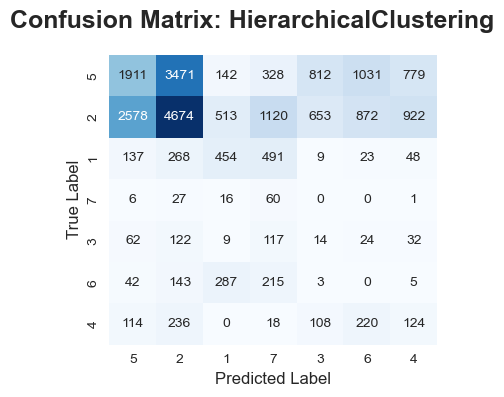

(0.31729329778708465, 0.3113893550191472)

In [74]:
# conduct_simple_experiment(skl.cluster.AgglomerativeClustering(n_clusters=n_targets))
conduct_simple_experiment(HierarchicalClustering(10, 10))

#### Grid Searched Agglomerative Clustering

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Evaluation: GSAC

#### **Best Val Accuracy:** `0.27171194883132455`

#### **Time Elapsed:** `15.7127 seconds`

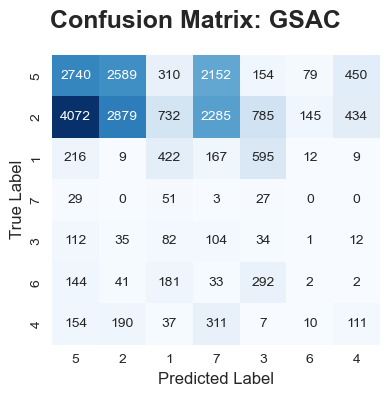

In [76]:
history_ac, *meta_ac = conduct_grid_search_experiment_v2("GSAC", search_space={
    'n_clusters': [10, 20, 30],
    'max_iter': [10, 20],
}, model_supplier=HierarchicalClustering, verbose=1, cv=2, n_jobs=3)

max_iter=10,n_clusters=30


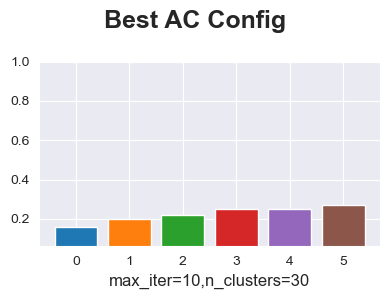

In [77]:
plot_model_comparsion("AC", history_ac)

### Gaussian Mixture Modelling

#### Simple GMM Example

In [78]:
class GaussianMixture(skl.mixture.GaussianMixture):
    def score(self, X, y=None, sample_weight=None):
        return skl.metrics.accuracy_score(y, self.predict(X))

C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


### Evaluation: GaussianMixture

#### **Train Accuracy:** `0.1009`

#### **Val Accuracy:** `0.1003`

#### **Test Multiclass ROC AUC Score (OVR):** `0.4574`

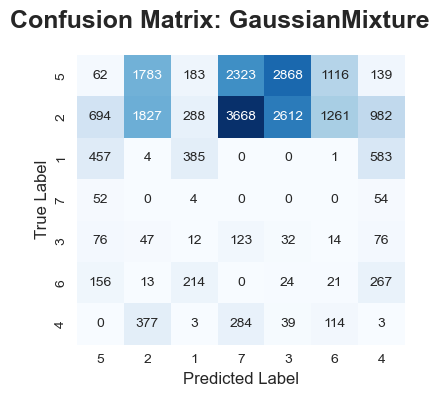

(0.10093748151122951, 0.10025386170990921)

In [79]:
conduct_simple_experiment(GaussianMixture(n_components=n_targets, max_iter=10))

#### Grid Searched Gaussian Mixture Modeling

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Initialization 0
  Iteration 10
Initialization did not converge.


### Evaluation: GSGM

#### **Best Val Accuracy:** `0.12529711774006394`

#### **Time Elapsed:** `115.1727 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.4574`

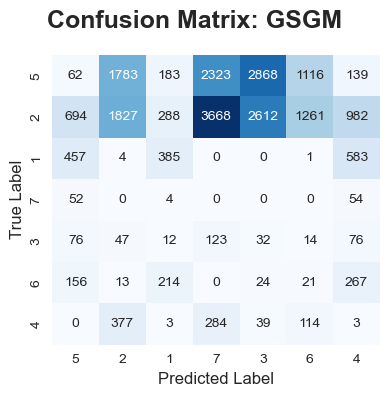

In [81]:
history_gm, *meta_gm = conduct_grid_search_experiment_v2("GSGM", search_space={
    'n_components': [n_targets],
    'max_iter': [10, 20],
}, model_supplier=GaussianMixture, verbose=1, cv=2)

max_iter=10,n_components=7


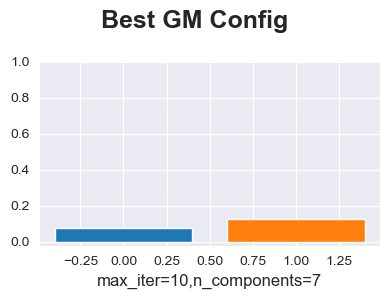

In [82]:
plot_model_comparsion("GM", history_gm)

### Density-Based Spatial Clustering of Applications with Noise

#### Simple DBS Example

In [83]:
class DBSCAN(skl.base.BaseEstimator, skl.base.ClusterMixin):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.x_ = None

    def fit(self, x, y=None):
        self.fit_predict(x)
        return self

    def predict(self, x):
        return self.fit_predict(x)

    def fit_predict(self, x, y=None):
        if self.x_ is not x:
            self.x_ = x
            self.dbs_ = skl.cluster.DBSCAN(eps=self.eps, min_samples=self.min_samples, n_jobs=12)
            self.dbs_.fit(x)
        return self.dbs_.labels_

    def score(self, X, y):
        return skl.metrics.accuracy_score(y, self.predict(X))

### Evaluation: DBSCAN

#### **Train Accuracy:** `0.0000`

#### **Val Accuracy:** `0.3437`

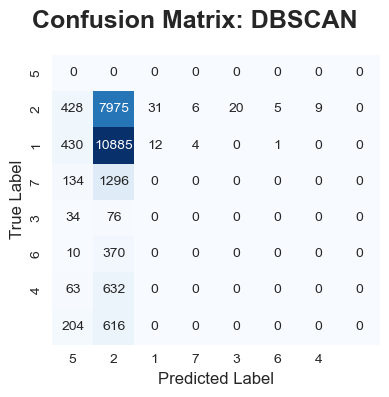

(0.0, 0.3436599113635386)

In [84]:
evaluate_model(DBSCAN(eps=1.673, min_samples=10), train_x[:10], train_y[:10], test_x, test_y, False)

#### Grid Searched DBScan

### Evaluation: GSDS

#### **Best Val Accuracy:** `0.34723140907144623`

#### **Time Elapsed:** `4.8982 seconds`

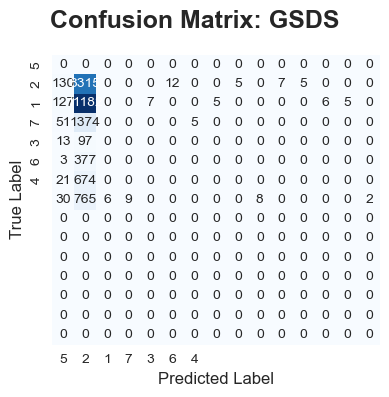

In [87]:
history_ds, *meta_ds = conduct_grid_search_experiment_v2("GSDS", search_space={
    'eps': [1.6, 1.65, 1.7, 1.75],
    'min_samples': [5, 10],
}, model_supplier=DBSCAN, verbose=1, cv=2, n_jobs=1, test_fit=True)

eps=1.75,min_samples=5


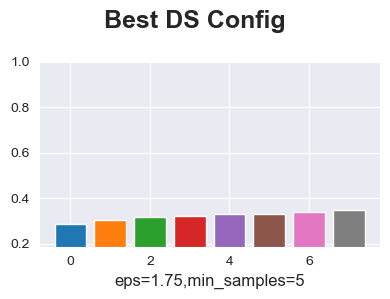

In [88]:
plot_model_comparsion("DS", history_ds)

## Comparasion

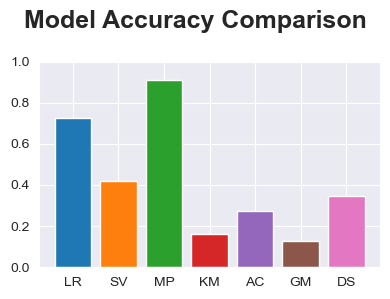

In [93]:
histories = {'lr': history_lr, 'sv': history_sv, 'mp': history_mp,
             'km': history_km, 'ac': history_ac, 'gm': history_gm, 'ds': history_ds}

metas = {'lr': meta_lr, 'sv': meta_sv, 'mp': meta_mp,
         'km': meta_km, 'ac': meta_ac, 'gm': meta_gm, 'ds': meta_ds}

plt.figure(figsize=sml_fig)
for idx, (model, history) in enumerate(histories.items()):
    plt.bar(idx, np.max([x[1]['val score'] for x in history]), label=model.upper())
plt.ylim(0, 1)
plt.xticks(range(len(histories)), [k.upper() for k in histories.keys()])
conclude_plot("Model Accuracy Comparison")

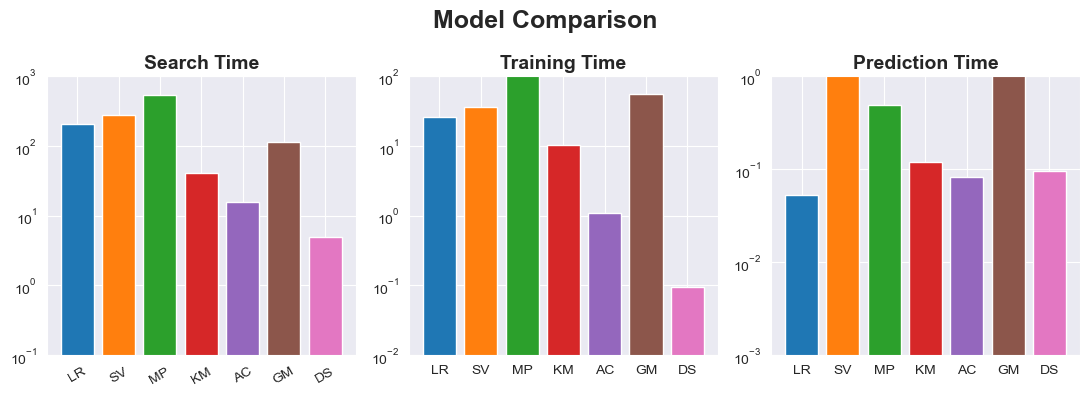

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(max_fig_width, 4))

for idx, (model, meta) in enumerate(metas.items()):
    axs[0].bar(idx, meta[3], label=model.upper())
axs[0].set_xticks(range(len(metas)), [k.upper() for k in metas.keys()], rotation=30)
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 1000)
annotate_plot(axs[0], "Search Time")

for idx, (model, history) in enumerate(histories.items()):
    axs[1].bar(idx, np.mean([x[1]['train_time'] for x in history]), label=model.upper())
axs[1].set_yscale('log')
axs[1].set_xticks(range(len(histories)), [k.upper() for k in histories.keys()])
axs[1].set_ylim(0.01, 100)
annotate_plot(axs[1], "Training Time")

for idx, (model, history) in enumerate(histories.items()):
    axs[2].bar(idx, np.mean([x[1]['pred_time'] for x in history]), label=model.upper())
axs[2].set_yscale('log')
axs[2].set_xticks(range(len(histories)), [k.upper() for k in histories.keys()])
axs[2].set_ylim(0.001, 1)
annotate_plot(axs[2], "Prediction Time")

conclude_plot("Model Comparison")

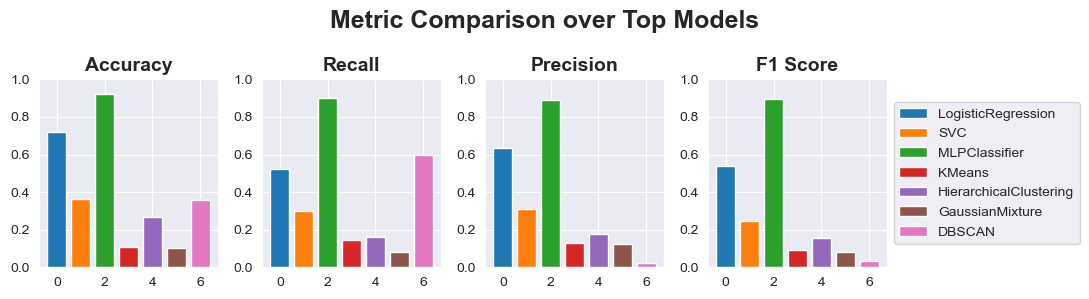

In [109]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))

# for iidx, meta in enumerate([meta_lr, meta_sv, meta_mp]):
for iidx, (model, meta) in enumerate(metas.items()):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        test_pred = meta[2].predict(test_x)
    for idx, (ax, name, score) in enumerate(zip(
            flatten(axs),
            ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
            [skl.metrics.accuracy_score, skl.metrics.recall_score, skl.metrics.precision_score, skl.metrics.f1_score],
    )):
        params = {}
        if 'average' in inspect.signature(score).parameters:
            params['average'] = 'macro'
        if 'zero_division' in inspect.signature(score).parameters:
            params['zero_division'] = 1
        value = score(test_y + (1 if model in ['lr', 'sv', 'mp'] else 0), test_pred, **params)
        ax.bar(iidx, value, label=meta[2].__class__.__name__)
        ax.set_ylim(0.0, 1.0)
        annotate_plot(ax, name)
plt.legend(ncol=1, bbox_to_anchor=(1, 0.5), loc='center left')
conclude_plot("Metric Comparison over Top Models", True)